## Pacchetti da installare

In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 30.0 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.1 MB/s eta 0:00:00

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import notebook

In [4]:
import os
import re
import datetime
import pathlib
import json
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

import matplotlib.pyplot as plt

In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Variabili Globali

In [6]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'dataset_dantesco.csv'
# train_filename = 'train_dataset_dantesco.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
# data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, data_filename))
train_data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_multi_bert_dante'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_multi_bert_dante'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
multilingual_vocab_finalname = 'multilingual_vocab_dante.txt'
dan_vocab_finalname = 'dan_vocab_dante.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
multilingual_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, multilingual_vocab_finalname))
dan_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, dan_vocab_finalname))

# parametri per il modello
ORIGINAL_COLUMN = 'Original'
TRANSLATE_COLUMN = 'Translate'

## Iper Parametri Modello

In [7]:
# Numero di esempi del dataset, esempi di test
NUM_SAMPLES = 30000 	 
TEST = 200
TEST_SIZE = 0.3

MAX_VOCAB_SIZE = 30000 
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 128

NUM_LAYERS = 1 # Numero di layer di Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 30

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## Parametri BERT

In [8]:
bert_model_name = 'distilbert_multi_cased_L-6_H-768_A-12/1'  
tfhub_handle_preprocess = 'https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2'
tfhub_handle_encoder =  'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1'

if debug:
  print('BERT model name                    : ', bert_model_name)
  print('BERT model selected                : ', tfhub_handle_encoder)
  print('BERT preprocess                    : ', tfhub_handle_preprocess)

BERT model name                    :  distilbert_multi_cased_L-6_H-768_A-12/1
BERT model selected                :  https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1
BERT preprocess                    :  https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2


## DATASET

### Caricamento Dati

In [9]:
def preprocess_sentence(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",", "'", "’")
  '''
  # inserimento di uno spazio tra ogni parola e il successivo punto,
  # punto esclamativo, punto interrogativo e virgola
  # esempio: "ciao, come và?" => "ciao , come và ?"
  w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

  # sostituzione dei caratteri apostrofo
  w = re.sub(r"([’]+)", "'", w)

  w = w.replace("á", "à")
  w = w.replace("é", "è")
  w = w.replace("í", "ì")
  w = w.replace("ó", "ò")
  w = w.replace("ú", "ù")
  w = w.replace('"', " ")
  w = w.replace(':', " ")
  w = w.replace('«', " ")
  w = w.replace('»', " ")
  w = w.replace('‘', " ")
  w = w.replace('-', " ")
  w = w.replace('[', " ")
  w = w.replace(']', " ")
  w = w.replace('(', " ")
  w = w.replace(')', " ")
  w = w.replace("•", " ")
  w = w.replace("..", ".")
  w = w.replace("...", ".")
  w = w.replace("\xa0", " ")
  w = w.replace("   ", " ")
  w = w.replace("–", " ")
  w = w.replace("“", " ")
  w = w.replace("”", " ")
  w = w.replace("„", " ")
  w = w.replace("─", " ")
  w = w.replace("♪", " ")
  w = w.replace("#", " ")
  w = w.replace("/", " ")
  w = w.replace("=", " ")
  w = w.replace(">", " ")
  w = w.replace("\\", " ")
  w = w.replace("`", " ")
  w = w.replace("¡", " ")
  w = w.replace("¿", " ")
  w = w.replace("œ", " ")

  # sostituzione dei caratteri non desiderati con uno spazio
  # w = re.sub(r"([^a-zA-Z?.!,'àèìòù]+)", " ", w)

  # inserimento di uno spazio dopo apostrofo
  w = re.sub(r"(['])", r"\1 ", w) 

  w = w.replace(" ' ", " '")

  w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
  return w

In [10]:
df = pd.read_csv(
  train_data_filenamepath,
  usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
  nrows=NUM_SAMPLES
)

# Preprocessing dei dati di Input
input_data = df[TRANSLATE_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[ORIGINAL_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

In [11]:
train_input_data, validation_input_data, train_target_data, validation_target_data = train_test_split(
  input_data[:-TEST], 
  target_data[:-TEST], 
  test_size=TEST_SIZE, 
  random_state=42,
  shuffle=True
) 

train_input_data = train_input_data[:(int((len(train_input_data) / BATCH_SIZE)) * BATCH_SIZE)]
train_target_data = train_target_data[:(int((len(train_target_data) / BATCH_SIZE)) * BATCH_SIZE)]

validation_input_data = validation_input_data[:(int((len(validation_input_data) / BATCH_SIZE)) * BATCH_SIZE)]
validation_target_data = validation_target_data[:(int((len(validation_target_data) / BATCH_SIZE)) * BATCH_SIZE)]

test_input_data = input_data[len(train_input_data)+len(validation_input_data):]
test_target_data = target_data[len(train_target_data)+len(validation_target_data):]

if debug:
  print(f'Dati totali presenti nel Dataset               : {len(df)}')
  print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
  print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
  print(f'Dati totali presenti nel Dataset di Test       : {len(test_input_data)}\n')


  print('----------------------------------- TRAIN SET -----------------------------------------')
  print(train_input_data[-4:])
  print(train_target_data[-4:])
  print('--------------------------------- VALIDATION SET --------------------------------------')
  print(validation_input_data[-4:])
  print(validation_target_data[-4:])
  print('----------------------------------- TEST SET ------------------------------------------')
  print(test_input_data[-4:])
  print(test_target_data[-4:])

  print('-------------------------------- ANALISI DATI -----------------------------------------')
  print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
  print(f'Frase più corta in nel Dataset di Train                : {min(train_input_data, key = len)}')
  print(f'Frase più corta in Dantesco nel Dataset di Train       : {min(train_target_data, key = len)}')
  print(f'Frase più lunga in nel Dataset di Train                : {max(train_input_data, key = len)}')
  print(f'Frase più lunga in Dantesco nel Dataset di Train       : {max(train_target_data, key = len)}')
  print('---------------------------------------------------------------------------------------')
  print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
  print(f'Frase più corta in nel Dataset di Validation           : {min(validation_input_data, key = len)}')
  print(f'Frase più corta in Dantesco nel Dataset di Validation  : {min(validation_target_data, key = len)}')
  print(f'Frase più lunga in nel Dataset di Validation           : {max(validation_input_data, key = len)}')
  print(f'Frase più lunga in Dantesco nel Dataset di Validation  : {max(validation_target_data, key = len)}')
  print('---------------------------------------------------------------------------------------')
  print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
  print(f'Frase più corta in nel Dataset di Test                 : {min(test_input_data, key = len)}')
  print(f'Frase più corta in Dantesco nel Dataset di Test        : {min(test_target_data, key = len)}')
  print(f'Frase più lunga in nel Dataset di Test                 : {max(test_input_data, key = len)}')
  print(f'Frase più lunga in Dantesco nel Dataset di Test        : {max(test_target_data, key = len)}')  

Dati totali presenti nel Dataset               : 30000
Dati totali presenti nel Dataset di Train      : 20832
Dati totali presenti nel Dataset di Validation : 8928
Dati totali presenti nel Dataset di Test       : 240

----------------------------------- TRAIN SET -----------------------------------------
['Fui al humilde jardìn . ', "Franchezza e Compassione dall' altro lato . ", 'Pero venga tanto como pueda a la corte , ', 'dans cette rèsistance à laquelle on croit']
["Nel giardin me n' andai molto gichito", "E Franchez' , e Pietà da l' altro lato", 'Ma venga il più che puote a la cielata , ', "In quello Schifo foll' è chi si crede , "]
--------------------------------- VALIDATION SET --------------------------------------
['Alors vous devriez demander rapidement . ', 'Impossibile , Inaccessibile , Irrealizzabile . ', 'Als Ergebnis , um meinen Freund zu begleiten , entschied ich mich . ', 'E così caccia via la paura , ']
['Allora in presto domandar dovesse', 'Che nessuna persona far p

## Tokenizer

Creo due differenti tokenizer che mi servizranno per la predisposizione dei dati di input:


*   EncTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Encoder di Bert
*   DecTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Decoder



In [12]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_multilingual = dataset.map(lambda multilingual, dan: multilingual)
train_dan = dataset.map(lambda multilingual, dan: dan)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [13]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [14]:
def cleanup_text(reserved_tokens, token_txt):

  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [15]:
tokenizers = tf.Module()

### Classe EncTokenizer

Classe custom per la tokenizzazione dei dati di Dante e che crea i tre vettori necessari al layer di Encoder 
Bert:


*   input_word_ids
*   input_type_ids
*   input_mask





In [16]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens = {
  'start_of_sequence_id': 101,
  'end_of_segment_id': 102,
  'padding_id': 0,
  'mask_id': 103
}

bert_vocab_args = dict(
  # The target vocabulary size
  vocab_size = MAX_VOCAB_SIZE,
  # Reserved tokens that must be included in the vocabulary
  reserved_tokens=reserved_tokens,
  # Arguments for `text.BertTokenizer`
  bert_tokenizer_params=bert_tokenizer_params,
  # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
  learn_params={},
)

In [17]:
exist_vocab = Path(multilingual_vocab_filenamepath)

if not exist_vocab.exists():
  multilingual_vocab = bert_vocab.bert_vocab_from_dataset(
      train_multilingual.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(multilingual_vocab_filenamepath, multilingual_vocab)

In [18]:
class EncTokenizer(tf.Module):
  def __init__(self, tfhub_handle_preprocess):
    self.preprocessor = hub.KerasLayer(tfhub_handle_preprocess)
    
  @tf.function
  def tokenize(self, strings):
    return self.preprocessor(strings)

In [19]:
tokenizers.multilingual = EncTokenizer(tfhub_handle_preprocess)

### Classe DecTokenizer

Classe custom per la tokenizzazione dei dati in lingua italiana per il layer di Decoder


In [20]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens_vocab=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
  # The target vocabulary size
  vocab_size = MAX_VOCAB_SIZE,
  # Reserved tokens that must be included in the vocabulary
  reserved_tokens=reserved_tokens_vocab,
  # Arguments for `text.BertTokenizer`
  bert_tokenizer_params=bert_tokenizer_params,
  # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
  learn_params={},
)

In [21]:
exist_vocab = Path(dan_vocab_filenamepath)

if not exist_vocab.exists():
  dan_vocab = bert_vocab.bert_vocab_from_dataset(
      train_dan.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(dan_vocab_filenamepath, dan_vocab)

In [22]:
START = tf.argmax(tf.constant(reserved_tokens_vocab) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens_vocab) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape(out_type=tf.int32)[0]

  starts = tf.fill([count,1], START)
  starts = tf.cast(starts, tf.int32)

  ends = tf.fill([count,1], END)
  ends = tf.cast(ends, tf.int32)

  x = tf.concat([starts, ragged, ends], axis=1)
  return x

In [23]:
class DecTokenizer(tf.Module):
  def __init__(self, reserved_tokens_vocab, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens_vocab
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens_vocab)

In [24]:
tokenizers.dan = DecTokenizer(reserved_tokens_vocab, dan_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [25]:
print(f'Vocabolario Dantesco : {tokenizers.dan.get_vocab_size()}')

Vocabolario Dantesco : 15268


In [26]:
print(input_data[-2:])
print(tokenizers.multilingual.tokenize(input_data[-2:])['input_word_ids'][:, :])
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.dan.tokenize(target_data[-2:]))

['Porque ninguno de ellos es tan viejo . ', 'que ella no se deleita en escuchar']
tf.Tensor(
[[  101 12399 11189 12411 25091 10104 16169 10196 15176 89775   119   102
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101 10121 15121 10192 10126 28250 11622 10110 10196 12352 39142   102
      0     0     0     0     0     0     

In [27]:
print([min(train_input_data, key = len)])
print(tokenizers.multilingual.tokenize([min(train_input_data, key = len)])['input_word_ids'][:, :32])
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.dan.tokenize([min(train_target_data, key = len)]))

['Y mirè y vi']
tf.Tensor(
[[  101   162 36077 13340   193 13956   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 32), dtype=int32)
------------------------------------------------------------------
['E gli giurai a le sante']
<tf.RaggedTensor [[2, 14, 154, 9993, 10, 47, 803, 3]]>


In [28]:
print([max(train_input_data, key = len)])
print(tokenizers.multilingual.tokenize([max(train_input_data, key = len)])['input_word_ids'])
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.dan.tokenize([max(train_target_data, key = len)]))

['Er ist vielleicht nicht feindseliger gegen mich , aber er wird vielleicht auf den Boden abgeschossen . ']
tf.Tensor(
[[   101  10915  10298 103118  10726  34778  32524  12912  20817  11930
   52866    117  11566  10163  10790 103118  10329  10140  37173  11357
   87654  10136    119    102      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0  

## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [29]:
def prepare_batch(multilingual, dan):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int32)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizers.multilingual.tokenize(multilingual)          

  # Tokenizzo l'input per il Decder e creo la variabile Target
  dan = tokenizers.dan.tokenize(dan)
  decoder = dan[:, :-1].to_tensor()  # Drop the [END] tokens
  target = dan[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [30]:
def make_batches(ds):
  return (
    ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(prepare_batch, tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [31]:
# Suddivido il dataset di validation in n parti per effettuare una validation incrociata
# num_record_validation = len(validation_input_data) / N_VALIDATION
# val_input_data = []
# val_target_data = []

# for i in range(N_VALIDATION):
#   df_input = validation_input_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]
#   df_target = validation_target_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]

#   val_input_data.append(df_input)
#   val_target_data.append(df_target)

In [32]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = make_batches(validation_dataset)

In [33]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- ENCODER  -------------------------------
Shape                    : (32, 128)
Word Ids                 : [  101 23962 13003 10141 13111 10911   171 32782 10123   117 10144 49301
 10294 15189 13340 73065   119   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Input Mask               : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [34]:
class EncoderBert(tf.keras.layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()

    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder', trainable=False)

    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :16]}')
      print(f'Input Mask                   : {x["input_mask"][0, :16]}')
      
    # x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    x = self.encoder(x)['encoder_outputs'] 
    x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :16]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.lambda_layer(x)
    if debug:
      print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :16]}')      
      print('*********************************************************') 

    return x

In [35]:
encoder_bert = EncoderBert(tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

bert_outputs = encoder_bert(enc_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_word_ids']
Shape                        : (32, 128)
Word Ids                     : [  101 23962 13003 10141 13111 10911   171 32782 10123   117 10144 49301
 10294 15189 13340 73065]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[ 0.04166945  0.02886187 -0.39438295  0.37144443  0.35344756  0.01152221
   0.45002556 -0.29816714  0.50440985  0.11343285 -0.04309499 -0.08482721
  -0.6772884  -0.04625734 -0.46117383  0.13576892]]

Sequence Conv1 Shape         : (32, 128, 512)
Sequence Conv2 Shape         : (32, 128, 128)
Sequence Lambda Layer        : (32, 128, 128)

Sequence Outputs Values      : [0.         0.21153858 0.         0.         0.52091676 0.
 0.70497346 0.36883223 0.16121268 0.2473058  0.24398106 0.00734796
 0.         0.         0.         0.1226691 ]
********

## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. 

In [36]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [37]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.dan.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 128
Sequence Shape                            : [ 32 128]
Shape TokenAndPositionEmbedding           : (32, 128, 128)
*********************************************************


### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

#### DecodeBert

Implmentazione di un blocco di  decodifica custom per decodificare l'output dal layer EncoderBert prima di passarlo al Decoder del Transformer tramite estensione della classe Layer di Keras

In [38]:
class DecodeBert(tf.keras.layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DecodeBert'):
    super(DecodeBert, self).__init__()
    self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = tf.keras.Sequential(
      [tf.keras.layers.Dense(ff_dim, activation='relu'), 
       tf.keras.layers.Dense(embed_dim),]
    )
    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, training=False, debug=False):
    attn_output = self.att(query=bert_outputs,
                           value=bert_outputs, 
                           key=bert_outputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(bert_outputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG DECODE-BERT *********************')
      print(f'Shape Input Layer Decode-Bert       : {bert_outputs.shape}')
      print(f'Shape Output Layer Decode-Bert      : {output.shape}')
      print('*********************************************************')

    return output

In [39]:
encoder = DecodeBert(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          training=training, 
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 128, 128)
Shape Output Layer Decode-Bert      : (32, 128, 128)
*********************************************************


#### Layer Decoder

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.decode_bert = DecodeBert(max_len=max_len, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    self.att1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = tf.keras.Sequential(
      [tf.keras.layers.Dense(ff_dim, activation='relu'), 
       tf.keras.layers.Dense(embed_dim),]
    )
    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.layernorm3 = tf.keras.layers.LayerNormalization()
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    dec_bert = self.decode_bert(bert_outputs=bert_outputs, training=training, debug=debug)

    attn_output2 = self.att2(key=dec_bert, 
                             value=dec_bert, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [41]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          bert_outputs=bert_outputs,  
                          training=training,
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 128, 128)
Shape Output Layer Decode-Bert      : (32, 128, 128)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 128, 128)
Shape Outputs Decoder             : (32, 128, 128)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [42]:
class TransformerBlock(tf.keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, embed_dim, max_len)
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug) 

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           bert_outputs=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [43]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.dan.get_vocab_size(),
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_word_ids']
Shape                        : (32, 128)
Word Ids                     : [  101 23962 13003 10141 13111 10911   171 32782 10123   117 10144 49301
 10294 15189 13340 73065]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[ 0.04166945  0.02886187 -0.39438295  0.37144443  0.35344756  0.01152221
   0.45002556 -0.29816714  0.50440985  0.11343285 -0.04309499 -0.08482721
  -0.6772884  -0.04625734 -0.46117383  0.13576892]]

Sequence Conv1 Shape         : (32, 128, 512)
Sequence Conv2 Shape         : (32, 128, 128)
Sequence Lambda Layer        : (32, 128, 128)

Sequence Outputs Values      : [0.20053855 0.35547173 0.54881424 0.         0.         0.
 0.91232276 0.         0.06727931 0.3616102  0.         0.30490062
 0.07974235 0.         0.19382127 0.        ]
********

In [44]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 1970688   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 135193472 
 )                                                               
                                                                 
 DEC (Decoder)               multiple                  1592224   
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  1969572   
                                                 

## Addestramento Modello

### Compilazione

In [45]:
transformer.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                     beta_1=BETA_1, 
                                     beta_2=BETA_2),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [46]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Create a callback Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
  on_epoch_end=lambda epoch, logs: json_log.write(
    json.dumps({'epoch': epoch, 
                'loss': logs['loss'],
                'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                'val_loss': logs['val_loss'],
                'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
  on_train_end=lambda logs: json_log.close()
)

### Train

In [47]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

ValueError: ignored

In [ ]:
start = datetime.datetime.now()
json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset,
                initial_epoch=0,
                epochs=EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/5
2952/2952 [==============================] - 2204s 744ms/step - loss: 1.2916 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.6870 - val_sparse_categorical_accuracy: 0.8983
Epoch 2/5
2952/2952 [==============================] - 2181s 739ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.6172 - val_sparse_categorical_accuracy: 0.9031
Epoch 3/5
2952/2952 [==============================] - 2228s 755ms/step - loss: 0.5913 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.9076
Epoch 4/5
2952/2952 [==============================] - 2220s 752ms/step - loss: 0.5431 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.5199 - val_sparse_categorical_accuracy: 0.9106
Epoch 5/5
2952/2952 [==============================] - 2218s 751ms/step - loss: 0.5040 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.4849 - val_sparse_categorical_accuracy: 0.9137
Tempo necessario per l'addestramento: 3:05:52.172142


In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset,
                initial_epoch=EPOCHS_ADAM,
                epochs=EPOCHS_ADAM+EPOCHS_ADAM,
                shuffle=True,
                validation_data=validation_dataset,
                callbacks=[tensorboard_callback,
                           json_logging_callback, 
                           cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 6/10
2952/2952 [==============================] - 2270s 767ms/step - loss: 0.4727 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.4613 - val_sparse_categorical_accuracy: 0.9155
Epoch 7/10
2952/2952 [==============================] - 2316s 784ms/step - loss: 0.4476 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.4429 - val_sparse_categorical_accuracy: 0.9168
Epoch 8/10
2952/2952 [==============================] - 2304s 781ms/step - loss: 0.4267 - sparse_categorical_accuracy: 0.9223 - val_loss: 0.4276 - val_sparse_categorical_accuracy: 0.9183
Epoch 9/10
2952/2952 [==============================] - 2292s 776ms/step - loss: 0.4089 - sparse_categorical_accuracy: 0.9242 - val_loss: 0.4094 - val_sparse_categorical_accuracy: 0.9202
Epoch 10/10
2952/2952 [==============================] - 2153s 729ms/step - loss: 0.3936 - sparse_categorical_accuracy: 0.9260 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.9214
Tempo necessario per l'addestramento: 3:09:34.160945


## Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

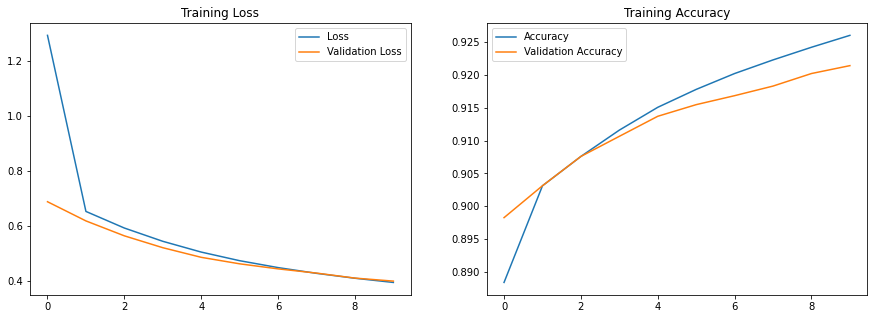

In [ ]:
# Recupero il log di addestramento
df_history = pd.read_json(log_history, lines=True)

# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(df_history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(df_history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    inputs_bert = self.tokenizers.multilingual.tokenize(input_text)

    start_end = self.tokenizers.dan.tokenize([''])[0]
    start = (start_end[0][tf.newaxis]).numpy()[0]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int32, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, tf.constant([start]))     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())

      transformer_output = transformer((inputs_bert, output), 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (tf.keras.backend.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.dan.detokenize(output)[0]  
    tokens = tokenizers.dan.lookup(output)[0]

    return text, tokens

In [ ]:

test_sequences = [test_input_data[2], test_input_data[26], test_input_data[19], 
                  test_input_data[34], test_input_data[45], test_input_data[58], 
                  test_input_data[62], test_input_data[71], test_input_data[84],
                  test_input_data[90], test_input_data[99], test_input_data[0]]

target_sequences = [test_target_data[2], test_target_data[26], test_target_data[19], 
                    test_target_data[34], test_target_data[45], test_target_data[58], 
                    test_target_data[62], test_target_data[71], test_target_data[84],
                    test_target_data[90], test_target_data[99], test_target_data[0]]
                    

In [ ]:
# test_sequences = test_input_data

# target_sequences = test_target_data

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence, target in zip(test_sequences, target_sequences):
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input":15s}: {test_sequence}')
  print(f'{"Target":15s}: {target}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

Input          : Om allt som har sagts om henne hade kondenserats till ett enda beröm , skulle det vara ogudaktigt att beskriva den beundran hon förtjänar . 
Target         :  Se quanto infino a qui di lei si dice fosse conchiuso tutto in una loda , poca sarebbe a fornir questa vice
Prediction     : se cio che ' l ' ultima salute , se ' l ' anima si fa che ' nvidiosi son di la sua grandezza in su per l dindi
---------------------------------------------
Input          : Dessutom sa han igen . 
Target         :  Anche soggiunse
Prediction     : poi disse
---------------------------------------------
Input          : Mitt på två stränder , utsmyckade av vackra vårblommor , såg jag ett ljus från den röda glöden som genljuder i form av en flod . 
Target         :  e vidi lume in forma di rivera fulvido di fulgore , intra due rive dipinte di mirabil primavera
Prediction     : e io vidi due luci de l ' un altro nascosto , e vidi a la , e vidi un poco a l ' alto burrato
----------------------